In [82]:
# --------------------------------------------------------------
# Latent-Space Face Impersonation (Reduced-Compute Variant)
# MSc Dissertation - Stella Williams
#
# This notebook implements an inversion-free latent-space
# impersonation experiment using:
#   - StyleGAN2-ADA (generator)
#   - FaceNet (verification backend)
#
# Objective:
# Generate a synthetic face whose embedding matches a selected
# target identity embedding, without reconstructing a source face.
#
# This models a target-synthesis threat scenario rather than
# source-to-target inversion.
# --------------------------------------------------------------




In [83]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1



In [84]:
"Cell 2: Device, FaceNet setup"
# --------------------------------------------------------------
# Device configuration
# --------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------------------------
# FaceNet embedding model (verification system)
# --------------------------------------------------------------

facenet = InceptionResnetV1(
    pretrained="vggface2"
).eval().to(device)

# --------------------------------------------------------------
# Preprocessing for FaceNet (160x160 input requirement)
# --------------------------------------------------------------

to_facenet = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    return img

def img_to_tensor(img):
    return to_facenet(img).unsqueeze(0).to(device)

@torch.no_grad()
def facenet_embed(img_tensor):
    emb = facenet(img_tensor)
    return nn.functional.normalize(emb, p=2, dim=1)

def cosine(a, b):
    return (a * b).sum(dim=1)


Using device: cpu


In [85]:
# --------------------------------------------------------------
# Load pretrained StyleGAN2-ADA generator
# --------------------------------------------------------------

STYLEGAN_PKL = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/Models/stylegan2-ffhq.pkl"

with open(STYLEGAN_PKL, "rb") as f:
    G = pickle.load(f)["G_ema"].to(device).eval()

print("Loaded StyleGAN2 generator")




Loaded StyleGAN2 generator


In [86]:
# --------------------------------------------------------------
# Generator wrapper
# Converts single w latent into w+ internally
# --------------------------------------------------------------

def synth_from_w_single(w):
    """
    w: [1, w_dim]
    Broadcast internally to w+ representation.
    Returns image in [0,1].
    """
    w_plus = w.unsqueeze(1).repeat(1, G.synthesis.num_ws, 1)
    img = G.synthesis(w_plus, noise_mode="const")
    img = (img + 1) / 2
    return img.clamp(0, 1)


In [87]:
# --------------------------------------------------------------
# Inversion-free initialisation
# Use average latent as starting point
# --------------------------------------------------------------

with torch.no_grad():
    w = G.mapping.w_avg.unsqueeze(0).to(device)

w = w.clone().detach().requires_grad_(True)

print("Initial latent shape:", w.shape)




Initial latent shape: torch.Size([1, 512])


In [88]:
# --------------------------------------------------------------
# Load target identity (impersonation objective)
# --------------------------------------------------------------

TARGET_A_PATH = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/Datasets/lfw/Lenny_Kravitz/Lenny_Kravitz_0001.jpg"

target_img = load_image(TARGET_A_PATH)
target_t = img_to_tensor(target_img)

with torch.no_grad():
    e_target = facenet_embed(target_t)

print("Target embedding norm:", e_target.norm().item())


Target embedding norm: 1.0


In [89]:
# --------------------------------------------------------------
# Reduced-compute latent impersonation loop
# --------------------------------------------------------------

optimizer = optim.Adam([w], lr=0.03)

MAX_STEPS = 80
TARGET_SIM = 0.85   # approximate verification threshold

for step in range(MAX_STEPS):
    
    # Generate synthetic face
    img = synth_from_w_single(w)
    img_160 = nn.functional.interpolate(img, (160, 160))
    
    # Compute embedding
    emb = facenet(img_160)
    emb = nn.functional.normalize(emb, dim=1)
    
    # Targeted impersonation objective
    sim = cosine(emb, e_target)
    loss = 1 - sim.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print(f"Step {step:03d} | cosine similarity = {sim.item():.4f}")
    
    # Early stopping if threshold reached
    if sim.item() >= TARGET_SIM:
        print("Early stop: impersonation threshold reached")
        break


Step 000 | cosine similarity = -0.0156
Step 010 | cosine similarity = 0.7614
Early stop: impersonation threshold reached


In [90]:
# --------------------------------------------------------------
# Final evaluation
# --------------------------------------------------------------

with torch.no_grad():
    final_img = synth_from_w_single(w)
    final_160 = nn.functional.interpolate(final_img, (160,160))
    emb_final = facenet_embed(final_160)

final_similarity = cosine(emb_final, e_target).item()

print("Final cosine similarity to target:", final_similarity)


Final cosine similarity to target: 0.8704956769943237


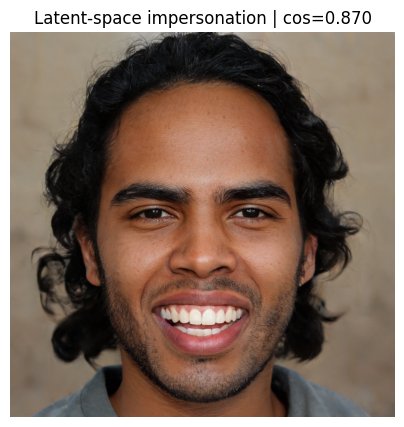

In [91]:
# --------------------------------------------------------------
# Visualise final generated adversarial face
# --------------------------------------------------------------

plt.figure(figsize=(5,5))
plt.imshow(final_img.squeeze().permute(1,2,0).cpu())
plt.title(f"Latent-space impersonation | cos={final_similarity:.3f}")
plt.axis("off")
plt.show()
